In [36]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'

In [86]:
from pathlib import Path

data_folder = '../datasets/infer'
# data_folder = '../datasets/valid-best'
# data_folder = '../datasets/valid-fixed'
# data_folder = '../datasets/train-fixed-whole/'
image_folder = f"{data_folder}/images"
masks_folder = f"{data_folder}/masks"
# files = [str(ss) for ss in sorted([s for s in Path(data_folder).glob('*.png')], key=lambda x: int(x.name.split('.')[0]))]
names = [Path(ss).name for ss in sorted([s for s in Path(image_folder).glob('*.png')], key=lambda x: int(x.name.split('.')[0]))]
image_files = [f"{image_folder}/{name}" for name in names]
mask_files = [f"{masks_folder}/{name}" for name in names]

In [87]:
import tensorflow as tf
import numpy as np
import segmentation_models as sm
from tensorflow.keras.models import load_model
sm.set_framework('tf.keras')

def load_model(checkpoint):
    model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=N_CLASSES, activation=ACTIVATION)
    model1.load_weights(checkpoint)
    return model1

N_CLASSES=2
ACTIVATION='softmax'

BACKBONE1 = 'resnet34'
# BACKBONE1 = 'resnet50'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# model1 = load_model('checkpoint_cleaning_aug_smarter_reduce_on_plat/resnet34_backbone_50epochs_bs1_lr0.0001.hdf5')
# model2 = load_model('checkpoint_cleaning_aug_smarter_reduce_on_plat/resnet34_backbone_50epochs_bs4_lr0.0001.hdf5')
# model2 = load_model('checkpoint_predicted/resnet34_backbone_50epochs_bs4_lr0.0001.hdf5')
model2 = load_model('checkpoint_best/resnet34_backbone_50epochs_bs1_lr0.0001.hdf5')

# model2 = load_model('checkpoint_predicted/resnet50_backbone_50epochs_bs4_lr0.0005_size640.hdf5')
# model2 = load_model('checkpoint_predicted/resnet50_backbone_50epochs_bs4_lr0.001_size640.hdf5')
# model2 = load_model('checkpoint_predicted/resnet50_backbone_50epochs_bs1_lr0.001.hdf5')
# model2 = load_model('checkpoint_predicted/resnet34_backbone_50epochs_bs1_lr0.0001.hdf5')
# model2 = load_model('checkpoint_aug/resnet34_backbone_50epochs.hdf5')

In [88]:
from typing import Tuple, List
import cv2
import albumentations as A

transform = A.CLAHE()
def decode_img(filename, size=None, channels=3, interpolation='bicubic', antialias=True):
    flag = cv2.IMREAD_COLOR
    if channels == 1:
        img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        img = np.expand_dims(img, axis=-1)
    else:
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = transform(image=img)['image']
    
    img = tf.convert_to_tensor(img)
    
#     img = tf.io.read_file(filename)
#     img = tf.io.decode_image(img, channels=channels)
    if size is not None:
        img = tf.image.resize(img, size, method=interpolation, antialias=antialias)
#     img = tf.clip_by_value(img, 0, 255)
#     img = tf.cast(img, dtype=tf.uint8)
    return img

def read_image(filename: str, size: Tuple[int,int]=None) -> tf.Tensor:
    return decode_img(filename, size, 3, interpolation='nearest', antialias=False)

def read_mask(filename, size=None):
    mask = decode_img(filename, size, 1, interpolation='nearest', antialias=False)
    mask = tf.cast(mask, tf.float32) / 255.
    mask = tf.squeeze(tf.cast(mask, tf.uint8))
    mask = tf.stack([1-mask, mask], axis=-1)
    return mask

def image_generator(image_files, mask_files, size_im, size_m=None, batch_size=1):
    def yieldify(ims, mas):
        return tf.stack(ims, axis=0),tf.stack(mas, axis=0)
    
    images = []
    masks = []
    for im, mas in zip(image_files, mask_files):
#         yield read_image(im, size_im), read_mask(mas, size_m)
        if len(images) >= batch_size:
            yield yieldify(images, masks)
            images = []
            masks = []
            
        images.append(read_image(im, size_im))
#         masks.append(read_mask(mas, size_m))
            
    if len(images) != 0:
        yield yieldify(images, masks)
        
def predict_batch(batch, model):
    return model.predict(batch, batch_size=len(batch), verbose=0)

def postprocess_preds(masks, target_size):
    masks = tf.image.resize(masks, target_size, 'nearest')
#     print(masks.shape)
    masks = tf.argmax(masks, axis=-1) 
    masks = tf.clip_by_value(masks* 255, 0, 255)
    masks = tf.cast(masks, tf.uint8)
    return masks

In [89]:
from tqdm import tqdm
# size = (640,640)
size = (1024,1024)
preds = [model2(tensor[0]).numpy() for tensor in tqdm(image_generator(image_files, mask_files, size, (1024,1024), batch_size=1))]

301it [00:42,  7.16it/s]


In [90]:
# masks1 = [postprocess_preds(pred, (1232, 1624)).numpy() for pred in preds1]
masks = [postprocess_preds(pred, (1232, 1624)).numpy() for pred in preds]

In [75]:
scores2 = []
for pred_masks, (_, gt_masks) in tqdm(zip(masks, image_generator(image_files, mask_files, (1024,1024), (1232, 1624), batch_size=1))):
    gt_masks = tf.cast(gt_masks, tf.float32)
    pred_masks_f = tf.cast(pred_masks,tf.float32)/255.0
    pred_masks_f = tf.stack([1-pred_masks_f, pred_masks_f], axis=-1)
#     scores.append(sm.metrics.f1_score(gt=gt_masks, pr=pred_masks_f).numpy())
    scores2 += [sm.metrics.f1_score(gt=gt_masks[i][tf.newaxis,], pr=pred_masks_f[i][tf.newaxis,]).numpy() for i in range(len(gt_masks))]
#     break
    
np.mean(scores2)

163it [00:10, 15.99it/s]
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [65]:
scores2 = []
for pred_masks, (_, gt_masks) in tqdm(zip(masks, image_generator(image_files, mask_files, (1024,1024), (1232, 1624), batch_size=16))):
    gt_masks = tf.cast(gt_masks, tf.float32)
    pred_masks_f = tf.cast(pred_masks,tf.float32)/255.0
    pred_masks_f = tf.stack([1-pred_masks_f, pred_masks_f], axis=-1)
#     scores.append(sm.metrics.f1_score(gt=gt_masks, pr=pred_masks_f).numpy())
    scores2 += [sm.metrics.f1_score(gt=gt_masks[i][tf.newaxis,], pr=pred_masks_f[i][tf.newaxis,]).numpy() for i in range(len(gt_masks))]
#     break
    
np.mean(scores2)

11it [00:10,  1.09it/s]


nan

In [28]:
scores = scores2

In [29]:
scores = np.array(scores)
argsorted = np.argsort(scores)
lowers = np.where(scores < np.mean(scores))

In [19]:
import matplotlib.pylab as plt
from PIL import Image

def plot_side_by_side(image1: Image.Image, image2: Image.Image, figsize=(10,10)):
    fig, ax =plt.subplots(1,2, figsize=figsize)
    ax[0].axis('off')
    ax[0].imshow(np.asarray(image1))
    
    ax[1].axis('off')
    ax[1].imshow(np.asarray(image2))
    
    plt.tight_layout()
    plt.show()

In [91]:
flatten_masks = np.concatenate(masks, axis=0)

In [25]:
from PIL import ImageOps

class Images:
    def __init__(self, filenames: List[str]):
        self.filenames = filenames
        
    def __getitem__(self, index):
        return Image.open(self.filenames[index])
    
    def __len__(self):
        return len(self.filenames)
    
class Masks:
    def __init__(self, filenames: List[str]):
        self.filenames = filenames
        
    def __getitem__(self, index):
        return ImageOps.invert(Image.open(self.filenames[index]).convert('L'))
    
    def __len__(self):
        return len(self.filenames)
    
def overlay_mask(image, mask, color=(255,0,0)):
    if not isinstance(image, Image.Image):
        image = Image.fromarray(image)
    if not isinstance(mask, Image.Image):
        mask = Image.fromarray(255-mask).convert('L')
        print(mask.size)
    return Image.composite(image, Image.new('RGB', image.size, color), mask)

In [45]:
all_images = Images(image_files)
all_masks = Masks(mask_files)

In [16]:
argsorted = np.arange(len(all_images))

In [17]:
np.array(names)[argsorted[:25]]

array(['784.png', '787.png', '788.png', '789.png', '791.png', '792.png',
       '795.png', '797.png', '798.png', '799.png', '800.png', '802.png',
       '803.png', '804.png', '805.png', '806.png', '807.png', '808.png',
       '809.png', '810.png', '811.png', '815.png', '816.png', '817.png',
       '818.png'], dtype='<U8')

In [14]:
np.array(names)[argsorted[:25]]

array(['347.png', '685.png', '349.png', '280.png', '160.png', '253.png',
       '410.png', '8.png', '504.png', '638.png', '518.png', '475.png',
       '256.png', '534.png', '564.png', '108.png', '401.png', '607.png',
       '444.png', '430.png', '178.png', '65.png', '13.png', '173.png',
       '70.png'], dtype='<U7')

In [54]:
names[index]

'528.png'

(1624, 1232)


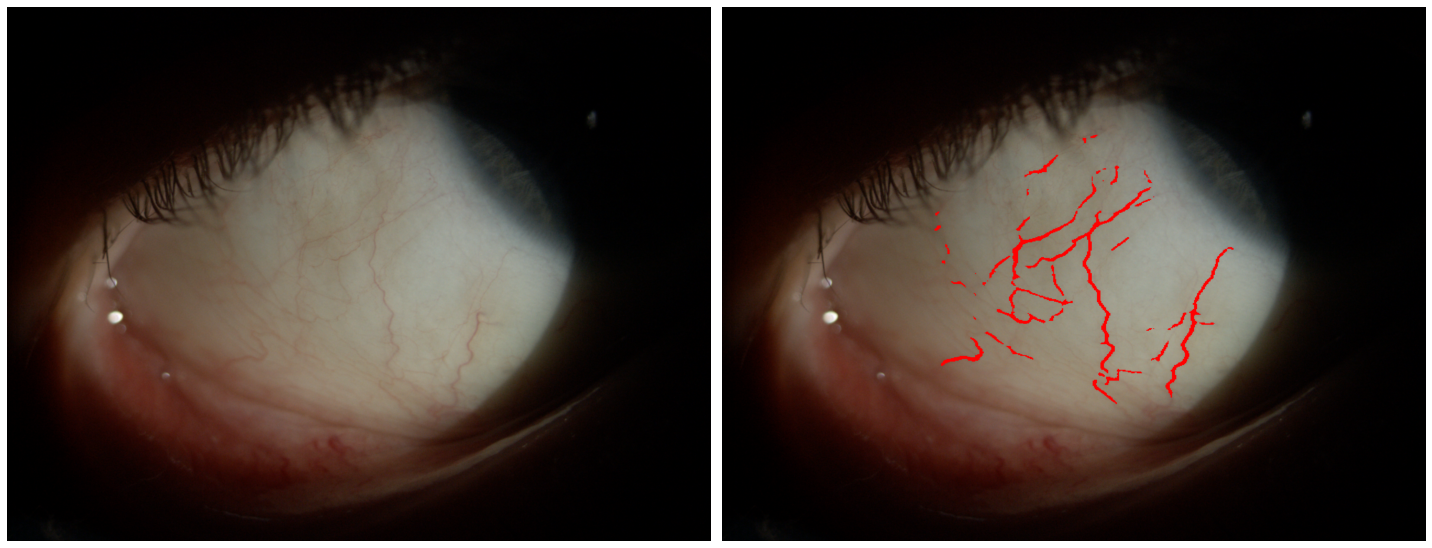

In [77]:
plot_side_by_side(all_images[index], overlay_mask(all_images[index], flatten_masks[index]), (20,20))

(1624, 1232)


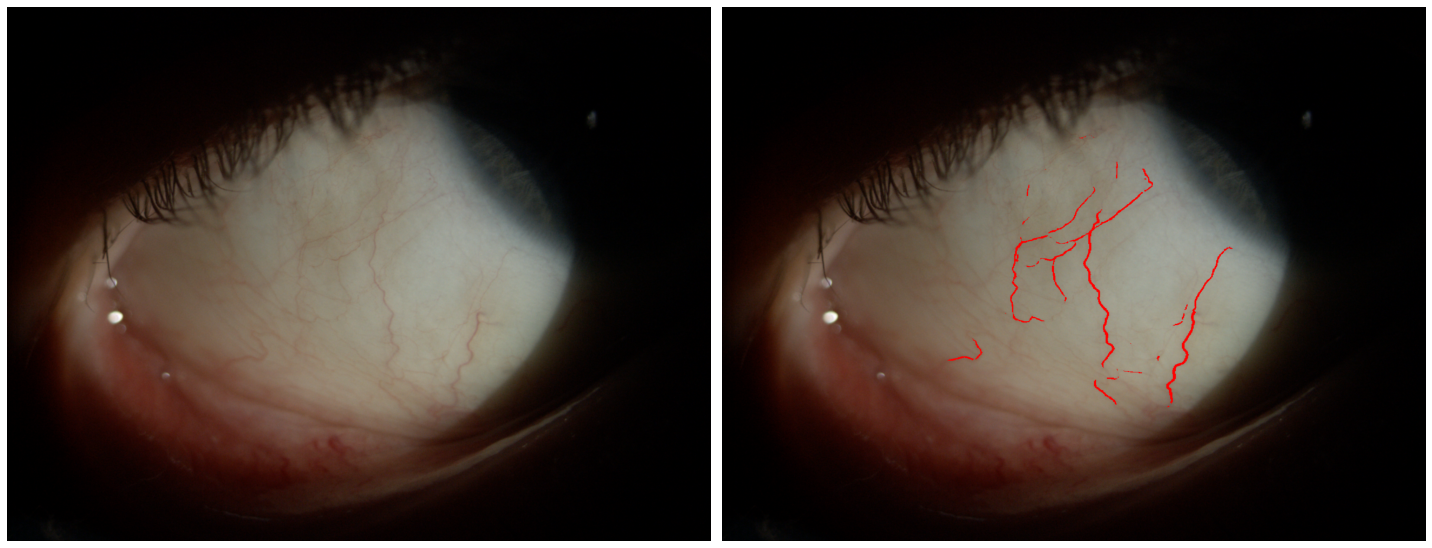

In [83]:
plot_side_by_side(all_images[index], overlay_mask(all_images[index], flatten_masks[index]), (20,20))

(1624, 1232)


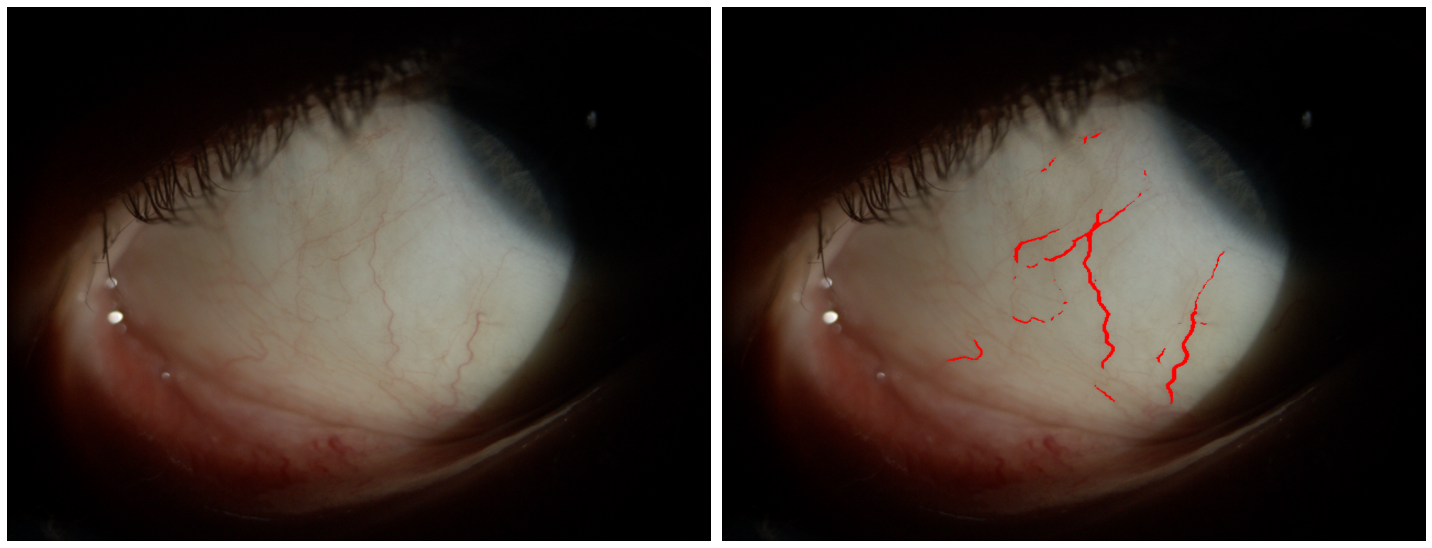

In [53]:
index = np.random.randint(len(names))
# index = argsorted[50]
# plot_side_by_side(all_images[index], overlay_mask(all_images[index], all_masks[index]), (20,20))
plot_side_by_side(all_images[index], overlay_mask(all_images[index], flatten_masks[index]), (20,20))

(1624, 1232)


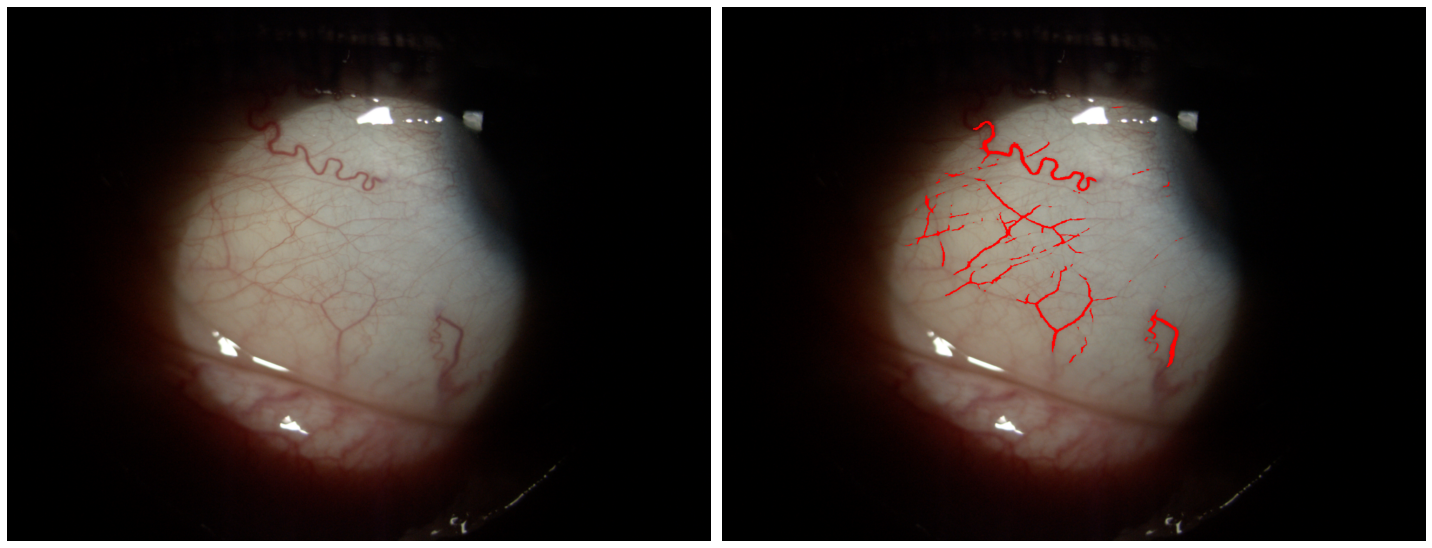

In [35]:
# index = argsorted[50]
# plot_side_by_side(all_images[index], overlay_mask(all_images[index], all_masks[index]), (20,20))
plot_side_by_side(all_images[index], overlay_mask(all_images[index], flatten_masks[index]), (20,20))

(1624, 1232)


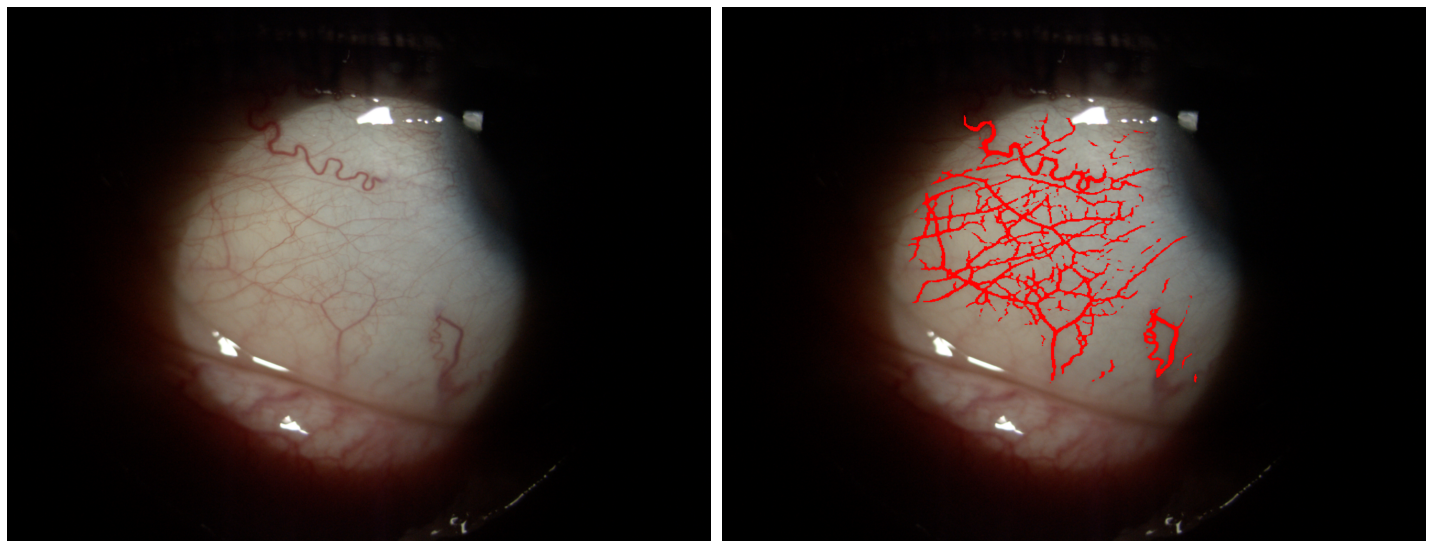

In [27]:
# index = argsorted[50]
# plot_side_by_side(all_images[index], overlay_mask(all_images[index], all_masks[index]), (20,20))
plot_side_by_side(all_images[index], overlay_mask(all_images[index], flatten_masks[index]), (20,20))

In [31]:
names[index]

'846.png'

(1624, 1232)


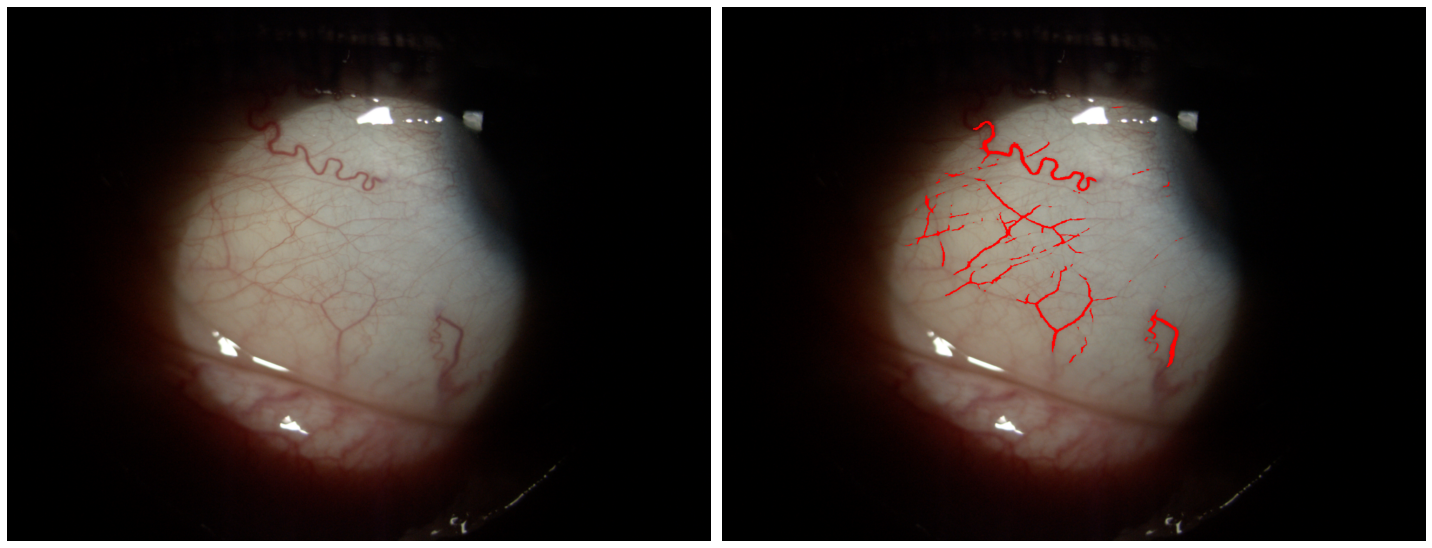

In [21]:
index = argsorted[50]
# plot_side_by_side(all_images[index], overlay_mask(all_images[index], all_masks[index]), (20,20))
plot_side_by_side(all_images[index], overlay_mask(all_images[index], flatten_masks[index]), (20,20))

In [52]:
scores[argsorted][0]

0.4951345

In [84]:
!mkdir submit-keras-14

In [92]:
!rm submit-keras-14/*

In [93]:
# mkdir

for i in tqdm(range(len(flatten_masks))):
    Image.fromarray(flatten_masks[i]).save(f"submit-keras-14/{names[i]}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [00:09<00:00, 32.05it/s]


In [21]:
def overlap_masks(masks: List[np.ndarray]):
    return np.max(np.stack(masks,axis=-1), axis=-1)

for i in tqdm(argsorted):
    overlapped = Image.fromarray(overlap_masks([255-np.asarray(all_masks[i]), flatten_masks[i]]))
    overlapped.save(f'../datasets/valid-predicted-whole/masks/{names[i]}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 163/163 [00:29<00:00,  5.61it/s]
